In [2]:
import pandas as pd
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Load the dataset
df = pd.read_json('news_data_final_1116.json')

# Initialize lemmatizer and load stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))  # Convert to a set for faster lookup

# Define a preprocessing function for English text
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^a-z\s]', '', text)  # Remove special characters
    words = nltk.word_tokenize(text)  # Tokenize
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words)

# Apply language detection and preprocessing
df['processed_title'] = df['title'].apply(preprocess_text)
df['processed_summary'] = df['summary'].apply(preprocess_text)

# Combine processed title and summary
df['combined_text'] = df['processed_title'] + ' ' + df['processed_summary']

# Check the first rows
df.head()

,title,author,published_date,published_date_precision,link,clean_url,excerpt,summary,rights,rank,...,language,authors,media,is_opinion,twitter_account,_score,_id,processed_title,processed_summary,combined_text
0,Help Move the Mission,Courtney George,2024-11-18 17:00:00,timezone unknown,https://www.ttnews.com/articles/help-move-mission,ttnews.com,Move The Mission: Wreaths Across America Seeks...,Are you seeking an opportunity to make a meani...,ttnews.com,12784,...,en,Courtney George,https://www.ttnews.com/sites/default/files/sty...,False,@TransportTopics,1.737079,3135bdd9e30ff99ae77af37ec8e57d11,help move mission,seeking opportunity make meaningful difference...,help move mission seeking opportunity make mea...
1,Indivisible spokesperson to present at Democra...,Rich Dunn,2024-11-18 13:00:00,timezone unknown,https://www.carsonnow.org/reader-content/11/15...,carsonnow.org,"Christiane Brown, a spokesperson for Indivisib...","Event Date:\nChristiane Brown, a spokesperson ...",carsonnow.org,59574,...,en,Rich Dunn,https://www.carsonnow.org/sites/www.carsonnow....,False,None,1.539347,66a4f6c69f5f96bea3d40aa0589d9e7e,indivisible spokesperson present democratic lu...,event date christiane brown spokesperson indiv...,indivisible spokesperson present democratic lu...
2,Movies Out of these actors/actresses - Who is ...,Daniel Day-Lewis,2024-11-18 08:08:20,timezone unknown,https://forums.sherdog.com/threads/out-of-thes...,sherdog.com,First Semi-Finals\nSecond Semi-Finals\nThe Fin...,First Semi-Finals\nSecond Semi-Finals\nThe Fin...,sherdog.com,12984,...,en,Daniel Day-Lewis,https://www.youtube.com/embed/MpDalntZPiw,False,None,1.734091,1164d98216f6595e179d58379a96ac65,movie actorsactresses best accent final ot,first semifinal second semifinal final two bes...,movie actorsactresses best accent final ot fir...
3,"WEEK IN CARTOONS: Election results, Elon Musk ...",,2024-11-18 00:00:00,timezone unknown,https://www.daytondailynews.com/configsection/...,daytondailynews.com,"WEEK IN CARTOONS: Election results, Elon Musk ...","Our apologies, unfortunately our website is cu...",daytondailynews.com,5929,...,en,,https://www.daytondailynews.com/resizer/v2/DAO...,False,@dayton-daily-news,1.945747,54cbdfc94a861693794ccc364ecc931f,week cartoon election result elon musk,apology unfortunately website currently unavai...,week cartoon election result elon musk apology...
4,NCPA updates its DSCSA checklist and SOP document,NCPA,2024-11-18 00:00:00,timezone unknown,https://www.ncpa.org/newsroom/qam/2024/11/18/n...,ncpa.org,Haven't thought about the Drug Supply Chain Se...,"NCPA November 18, 2024\nHaven't thought about ...",ncpa.org,20084,...,en,NCPA,https://ncpa.org/sites/default/files/2020-03/n...,False,@Commpharmacy,1.837349,4d7e1ed791cf94d302b1ec140a9cacb7,ncpa update dscsa checklist sop document,ncpa november havent thought drug supply chain...,ncpa update dscsa checklist sop document ncpa ...


In [3]:

import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import seaborn as sns
import matplotlib.pyplot as plt


df.drop(columns='published_date_precision', inplace=True)
df.drop(columns='_id', inplace=True)
df.drop(columns='_score', inplace=True)

# Extract numerical date features
df['published_date'] = pd.to_datetime(df['published_date'], errors='coerce')
df['year'] = df['published_date'].dt.year
df['month'] = df['published_date'].dt.month
df['day_of_week'] = df['published_date'].dt.dayofweek

df['combined_text'] = df['combined_text'].apply(lambda x: re.sub(r'[^\x00-\x7F]+', ' ', x)).str.replace(r'\s+', ' ', regex=True).str.strip()
df['combined_text'] = df['combined_text'].str.lower()

df.head()

,title,author,published_date,link,clean_url,excerpt,summary,rights,rank,topic,...,authors,media,is_opinion,twitter_account,processed_title,processed_summary,combined_text,year,month,day_of_week
0,Help Move the Mission,Courtney George,2024-11-18 17:00:00,https://www.ttnews.com/articles/help-move-mission,ttnews.com,Move The Mission: Wreaths Across America Seeks...,Are you seeking an opportunity to make a meani...,ttnews.com,12784,news,...,Courtney George,https://www.ttnews.com/sites/default/files/sty...,False,@TransportTopics,help move mission,seeking opportunity make meaningful difference...,help move mission seeking opportunity make mea...,2024,11,0
1,Indivisible spokesperson to present at Democra...,Rich Dunn,2024-11-18 13:00:00,https://www.carsonnow.org/reader-content/11/15...,carsonnow.org,"Christiane Brown, a spokesperson for Indivisib...","Event Date:\nChristiane Brown, a spokesperson ...",carsonnow.org,59574,news,...,Rich Dunn,https://www.carsonnow.org/sites/www.carsonnow....,False,None,indivisible spokesperson present democratic lu...,event date christiane brown spokesperson indiv...,indivisible spokesperson present democratic lu...,2024,11,0
2,Movies Out of these actors/actresses - Who is ...,Daniel Day-Lewis,2024-11-18 08:08:20,https://forums.sherdog.com/threads/out-of-thes...,sherdog.com,First Semi-Finals\nSecond Semi-Finals\nThe Fin...,First Semi-Finals\nSecond Semi-Finals\nThe Fin...,sherdog.com,12984,news,...,Daniel Day-Lewis,https://www.youtube.com/embed/MpDalntZPiw,False,None,movie actorsactresses best accent final ot,first semifinal second semifinal final two bes...,movie actorsactresses best accent final ot fir...,2024,11,0
3,"WEEK IN CARTOONS: Election results, Elon Musk ...",,2024-11-18 00:00:00,https://www.daytondailynews.com/configsection/...,daytondailynews.com,"WEEK IN CARTOONS: Election results, Elon Musk ...","Our apologies, unfortunately our website is cu...",daytondailynews.com,5929,news,...,,https://www.daytondailynews.com/resizer/v2/DAO...,False,@dayton-daily-news,week cartoon election result elon musk,apology unfortunately website currently unavai...,week cartoon election result elon musk apology...,2024,11,0
4,NCPA updates its DSCSA checklist and SOP document,NCPA,2024-11-18 00:00:00,https://www.ncpa.org/newsroom/qam/2024/11/18/n...,ncpa.org,Haven't thought about the Drug Supply Chain Se...,"NCPA November 18, 2024\nHaven't thought about ...",ncpa.org,20084,news,...,NCPA,https://ncpa.org/sites/default/files/2020-03/n...,False,@Commpharmacy,ncpa update dscsa checklist sop document,ncpa november havent thought drug supply chain...,ncpa update dscsa checklist sop document ncpa ...,2024,11,0


In [4]:
# Predefined labels for filtering and classification
valid_labels = {'sport', 'tech', 'world', 'finance', 'politics', 'business',
                'economics', 'entertainment', 'beauty', 'travel', 'music',
                'food', 'science', 'gaming', 'energy'}

# Filter rows where the topic is in the valid labels set
df_valid = df[df['topic'].isin(valid_labels)].copy()

# Identify rows with missing topics to classify later
missing_topics_df = df[~df['topic'].isin(valid_labels)].copy()

# Feature extraction using TF-IDF for valid data
vectorizer = TfidfVectorizer(max_features=5000)
X_valid = vectorizer.fit_transform(df_valid['combined_text'])
y_valid = df_valid['topic']

# Split data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(X_valid, y_valid, test_size=0.2, random_state=42)

# Train a classifier (Naive Bayes example)
classifier = MultinomialNB()
classifier.fit(X_train, y_train)

# Predict on the validation set
y_pred_val = classifier.predict(X_val)

# Evaluate the model
print("Accuracy on Validation Set:", accuracy_score(y_val, y_pred_val))
print("Classification Report:\n", classification_report(y_val, y_pred_val))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred_val))

# Transform combined_text for rows with missing topics using the same vectorizer
X_missing = vectorizer.transform(missing_topics_df['combined_text'])

# Predict the missing topics
predicted_topics = classifier.predict(X_missing)

# Assign predicted topics back to the missing rows
df.loc[~df['topic'].isin(valid_labels), 'topic'] = predicted_topics

df.head()

Accuracy on Validation Set: 0.4769874476987448
Classification Report:
                precision    recall  f1-score   support

       beauty       0.00      0.00      0.00         2
     business       0.50      0.33      0.40        27
    economics       1.00      0.36      0.53        11
       energy       0.00      0.00      0.00         7
entertainment       0.88      0.26      0.40        27
      finance       1.00      0.60      0.75         5
         food       0.00      0.00      0.00         2
       gaming       0.78      0.18      0.30        38
        music       0.00      0.00      0.00         4
     politics       0.50      0.14      0.22        14
      science       0.00      0.00      0.00         7
        sport       0.39      0.94      0.55        70
         tech       0.00      0.00      0.00         3
        world       0.64      0.73      0.68        22

     accuracy                           0.48       239
    macro avg       0.41      0.25      0.27   

c:\Users\PhucDo\miniconda3\envs\data_mining\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\PhucDo\miniconda3\envs\data_mining\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\PhucDo\miniconda3\envs\data_mining\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

,title,author,published_date,link,clean_url,excerpt,summary,rights,rank,topic,...,authors,media,is_opinion,twitter_account,processed_title,processed_summary,combined_text,year,month,day_of_week
0,Help Move the Mission,Courtney George,2024-11-18 17:00:00,https://www.ttnews.com/articles/help-move-mission,ttnews.com,Move The Mission: Wreaths Across America Seeks...,Are you seeking an opportunity to make a meani...,ttnews.com,12784,sport,...,Courtney George,https://www.ttnews.com/sites/default/files/sty...,False,@TransportTopics,help move mission,seeking opportunity make meaningful difference...,help move mission seeking opportunity make mea...,2024,11,0
1,Indivisible spokesperson to present at Democra...,Rich Dunn,2024-11-18 13:00:00,https://www.carsonnow.org/reader-content/11/15...,carsonnow.org,"Christiane Brown, a spokesperson for Indivisib...","Event Date:\nChristiane Brown, a spokesperson ...",carsonnow.org,59574,sport,...,Rich Dunn,https://www.carsonnow.org/sites/www.carsonnow....,False,None,indivisible spokesperson present democratic lu...,event date christiane brown spokesperson indiv...,indivisible spokesperson present democratic lu...,2024,11,0
2,Movies Out of these actors/actresses - Who is ...,Daniel Day-Lewis,2024-11-18 08:08:20,https://forums.sherdog.com/threads/out-of-thes...,sherdog.com,First Semi-Finals\nSecond Semi-Finals\nThe Fin...,First Semi-Finals\nSecond Semi-Finals\nThe Fin...,sherdog.com,12984,sport,...,Daniel Day-Lewis,https://www.youtube.com/embed/MpDalntZPiw,False,None,movie actorsactresses best accent final ot,first semifinal second semifinal final two bes...,movie actorsactresses best accent final ot fir...,2024,11,0
3,"WEEK IN CARTOONS: Election results, Elon Musk ...",,2024-11-18 00:00:00,https://www.daytondailynews.com/configsection/...,daytondailynews.com,"WEEK IN CARTOONS: Election results, Elon Musk ...","Our apologies, unfortunately our website is cu...",daytondailynews.com,5929,sport,...,,https://www.daytondailynews.com/resizer/v2/DAO...,False,@dayton-daily-news,week cartoon election result elon musk,apology unfortunately website currently unavai...,week cartoon election result elon musk apology...,2024,11,0
4,NCPA updates its DSCSA checklist and SOP document,NCPA,2024-11-18 00:00:00,https://www.ncpa.org/newsroom/qam/2024/11/18/n...,ncpa.org,Haven't thought about the Drug Supply Chain Se...,"NCPA November 18, 2024\nHaven't thought about ...",ncpa.org,20084,sport,...,NCPA,https://ncpa.org/sites/default/files/2020-03/n...,False,@Commpharmacy,ncpa update dscsa checklist sop document,ncpa november havent thought drug supply chain...,ncpa update dscsa checklist sop document ncpa ...,2024,11,0


In [5]:
# Extract sentiment score from summary
analyzer = SentimentIntensityAnalyzer()
df['sentiment_score'] = df['combined_text'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
# Classify sentiment into 1-5 scale
def sentiment_category(score):
    if score >= 0.6:
        return 5  # Very positive
    elif score >= 0.2:
        return 4  # Positive
    elif score > -0.2:
        return 3  # Neutral
    elif score > -0.6:
        return 2  # Negative
    else:
        return 1  # Very negative

df['sentiment_category'] = df['sentiment_score'].apply(sentiment_category)



In [6]:
# Frequency encoding function
def frequency_encode(df, column):
    freq = df[column].value_counts(normalize=True)
    return df[column].map(freq)

# Apply frequency encoding to categorical columns
categorical_columns = ['author', 'clean_url', 'country', 'twitter_account']

# Handle missing values
df['author'].fillna('Unknown', inplace=True)
df['author'].replace('', 'Unknown', inplace=True)
df['clean_url'].fillna('Unknown', inplace=True)
df['clean_url'].replace('', 'Unknown', inplace=True)
df['country'].fillna('Unknown', inplace=True)
df['country'].replace('', 'Unknown', inplace=True)
df['twitter_account'].fillna('Unknown', inplace=True)
df['twitter_account'].replace('', 'Unknown', inplace=True)

for col in categorical_columns:
    df[col + '_freq'] = frequency_encode(df, col)

# Optional: Drop original columns if they are no longer needed
# df.drop(columns=categorical_columns, inplace=True)


C:\Users\PhucDo\AppData\Local\Temp\ipykernel_25656\2658083195.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['author'].fillna('Unknown', inplace=True)
C:\Users\PhucDo\AppData\Local\Temp\ipykernel_25656\2658083195.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exa

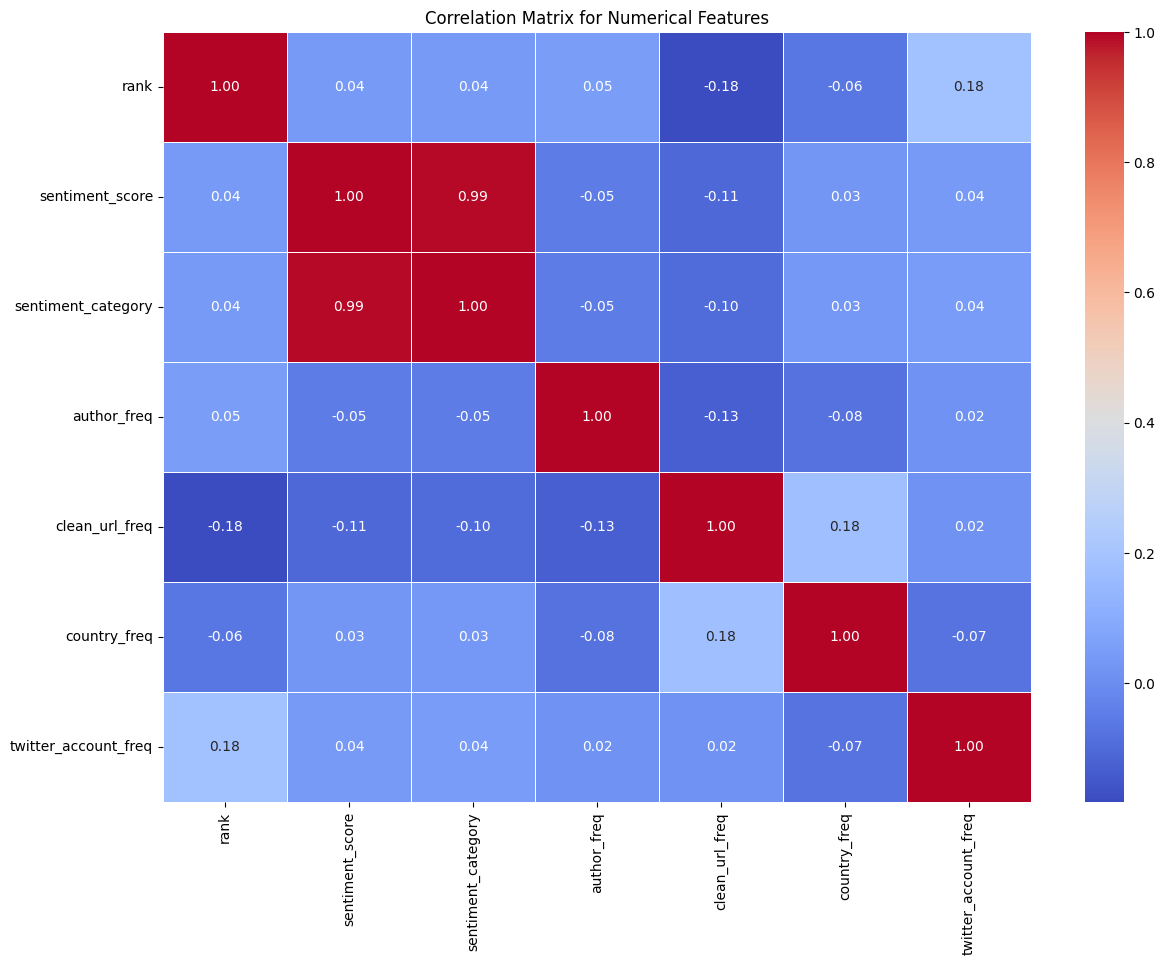

In [7]:
import json
df.drop(columns=['year', 'month', 'day_of_week'], inplace=True)
# Calculate the correlation matrix for numerical and derived features
numerical_columns = df.select_dtypes(include=[np.number]).columns
correlation_matrix = df[numerical_columns].corr()


correlation_dict = correlation_matrix.to_dict()
correlation_json = json.dumps({"correlation_matrix": correlation_dict}, indent=4)
with open("correlation_matrix.json", "w") as f:
    f.write(correlation_json)
# # Plot the correlation heatmap
# plt.figure(figsize=(14, 10))
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
# plt.title('Correlation Matrix')
# plt.show()
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix for Numerical Features')
plt.show()

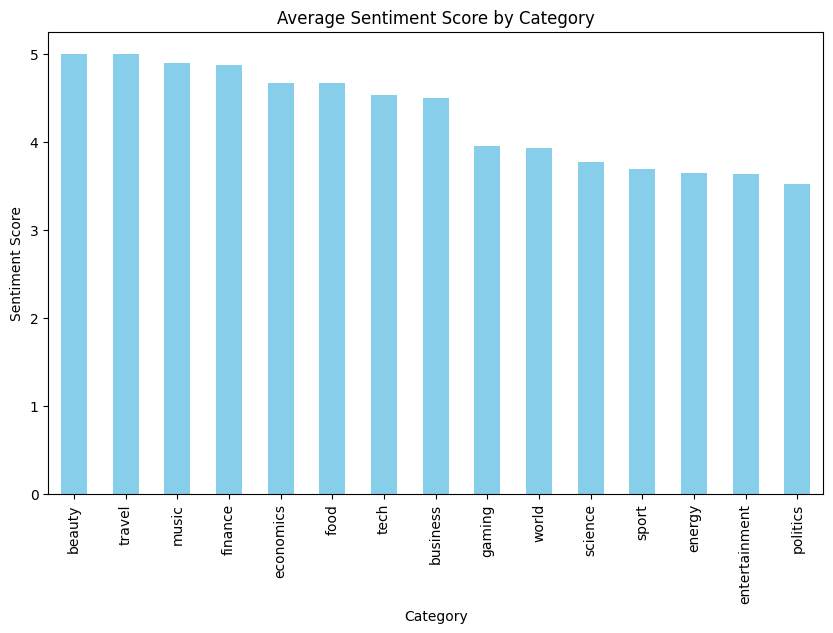

In [9]:
# Group by topic and calculate the average sentiment score and count
sentiment_summary = df.groupby('topic')['sentiment_category'].agg(['mean', 'count'])

# Plot average sentiment score by topic
sentiment_summary.sort_values('mean', ascending=False)['mean'].plot(kind='bar', figsize=(10, 6), color='skyblue')
plt.title('Average Sentiment Score by Category')
plt.ylabel('Sentiment Score')
plt.xlabel('Category')
plt.show()